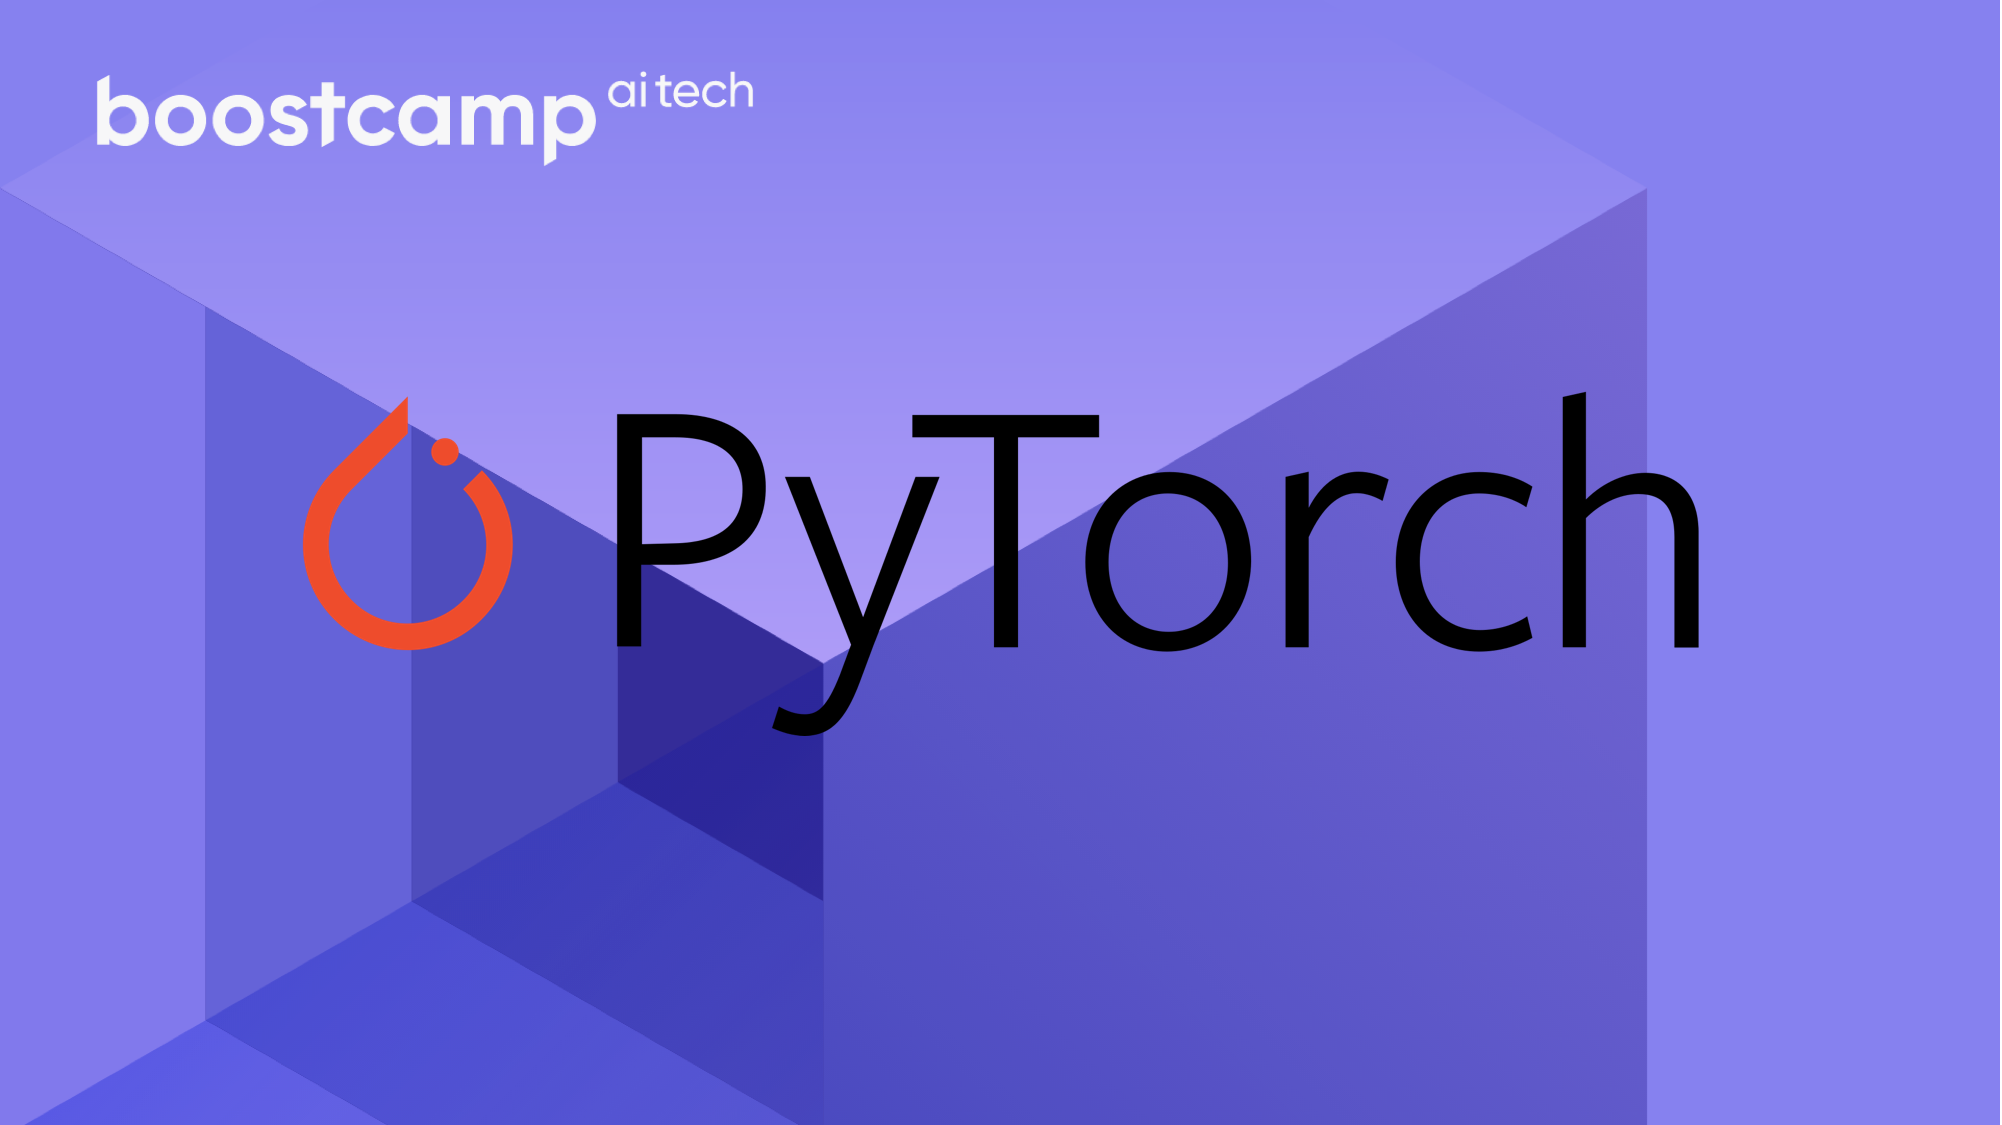

# Pytorch 선택과제

# Transfer Learning and Hyperparameter Tuning

TL;DR : 이번 실습에서는 Convolutional Neural Networks에서 Transfer Learning (Fine-Tune, torchvision) 과 Hyperparemter Tuning을 위한 pytorch 및 추가 라이브러리(Ray Tune) 사용법을 간단하게 학습합니다. 

본 장에서 `(채워넣기)`로 되어 있는 부분은 답안지가 추후 제공되는 부분입니다 :)

본 장에서 `(참고.해보기)`로 나오는 것은 캠퍼분들이 스스로 더 찾아보면서 진행해보시길 권장하는 내용들입니다. 본 노트북에서는 정답이 없고, `#질문게시판`에서 토론 및 질문들을 진행하면 좋겠습니다

## 실습 내용

Fashion-Mnist라는 10개의 의류 종류(반팔, 신발, 가방 등)를 포함한 데이터셋을 분류하는 딥러닝 방법론 중 하나인 Convolutional Neural Networks 모델을 Transfer Learning으로 학습 하겠습니다.

___

## Transfer Learning

현실의 문제를 다룰 때, 정제된 충분한 데이터를 수집하는 일은 어렵습니다. 이에 따라 적은 데이터로 좋은 모델을 만드는 방법론이 다양하게 개발되었는데, 그 중 하나가 Transfer Learning 방법론이 있습니다.

Transfer Learning은 지식 전이(Knowledge Transfer)를 위한 방법론으로, "Source Tasks"에서 학습된 지식을 "Target Task"로 전이하는 절차 및 방법론을 의미합니다.

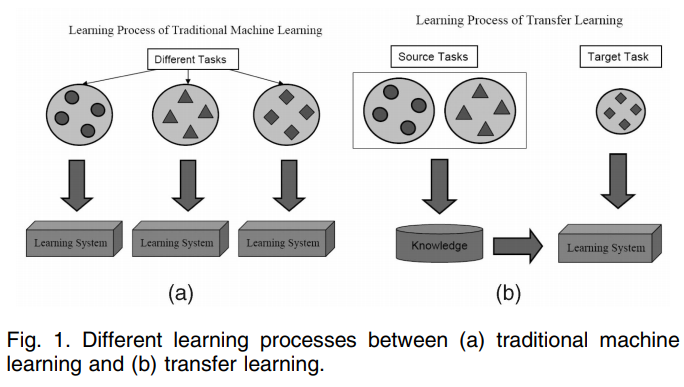


Source Tasks과 Target Tasks에 정답(Label)의 유무에 따라 다양한 Transfer Learning 방법론이 사용될 수 있습니다만, 이번 실습에서는 Source Tasks와 Target Tasks에 모두 정답이 있는 상황에서 사용될 수 있는 "Fine-Tuning"을 실습합니다.

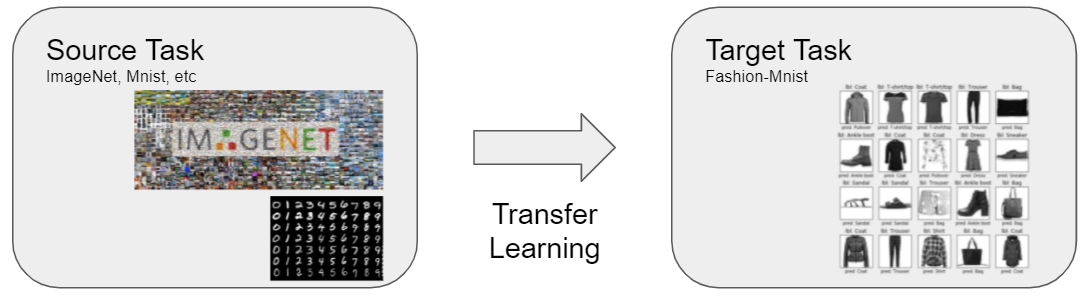

### 1. Source Task 모델 생성

우리가 Target으로 하고 있는 Fashion-Mnist (Target Task)를 분류하는 모델을 만들기 위해, 지식을 전이할 Source Task 모델을 만들어보겠습니다.

Pytorch 개발팀에서는 Tensor 연산을 위한 pytorch 라이브러리 외에 음성 데이터 및 모델을 다루기 위한 torchaudio, 영상 데이터 및 모델을 위한 torchvision, 모델 서빙을 위한 torchserve 등의 다양한 추가 라이브러리를 개발하여 제공하고 있습니다. 이번 실습에서는 torchvision에서 데이터 및 모델을 불러오는 방법을 보겠습니다.

In [1]:
import torchvision
import torch

import numpy as np

### 1.1 ImageNet Pretrained Model을 torchvision에서 불러오기

In [2]:
# ImageNet에서 학습된 ResNet 18 딥러닝 모델을 불러옴
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)
print("네트워크 필요 입력 채널 개수", imagenet_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", imagenet_resnet18.fc.weight.shape[0])
print(imagenet_resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 1000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

### 1.2 Mnist Pretrained Model 만들기

#### 1.2.1 Mnist Dataset 불러오기

In [4]:
# mnist train 데이터와 test 데이터 불러오기 - Mnist 데이터셋은 0부터 9까지 손으로 쓰인 10가지의 클래스가 있는 데이터셋입니다.
# ref : http://yann.lecun.com/exdb/mnist/
mnist_train = torchvision.datasets.MNIST(root='./mnist', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./mnist', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 이미지 시각화를 위한 코드
import matplotlib.pyplot as plt
%matplotlib inline

image class is 5
(<PIL.Image.Image image mode=L size=28x28 at 0x7F1DE5AE9090>, 5)


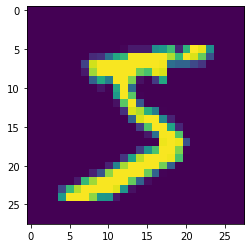

In [12]:
IMAGE_INDEX = 0 # 이 숫자를 바꿔가면서 다른 이미지도 확인해 보세요!
plt.imshow(mnist_train[IMAGE_INDEX][0])
print(f"image class is {mnist_train[IMAGE_INDEX][1]}")
print(mnist_train[0])

#### 1.2.2 Mnist를 학습할 CNN 모델 생성하기 (Resnet18)

In [13]:
mnist_resnet18 = torchvision.models.resnet18(pretrained=False)
print("네트워크 필요 입력 채널 개수", mnist_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", mnist_resnet18.fc.weight.shape[0])
print("네트워크 구조", mnist_resnet18)

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 1000
네트워크 구조 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

#### 1.2.3 Mnist 데이터 분류 Resnet18 모델에 학습하기

In [15]:
# torchvision.datasets.mnist의 데이터 타입은 PIL Image이고, 학습 때는 torch로 type 변경이 필요함
# + 원본 영상은 grayscale이라서 채널이 한개뿐인 입력이지만 모델은 3채널이기 때문에 grayscale을 RGB로 변경해주어야함
# (참고.해보기) grayscale의 입력을 모델에 넣고 싶으면, 모델 입력을 channel 1개만 받도록 변경할 수도 있다! (hint - `mnist_resnet18.conv1 = nn.Conv2d(...)`)
print('원본', type(mnist_train[0][0]), np.array(mnist_train[0][0]).shape)

common_transform = torchvision.transforms.Compose(
  [
    torchvision.transforms.Grayscale(num_output_channels=3), # grayscale의 1채널 영상을 3채널로 동일한 값으로 확장함
    torchvision.transforms.ToTensor() # PIL Image를 Tensor type로 변경함
  ]
)
# 앞서 선언한 데이터셋에 transform 인자를 넘겨주자
mnist_train_transformed = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=common_transform)
mnist_test_transformed = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=common_transform)

print('변경됨', type(mnist_train_transformed[0][0]), np.array(mnist_train_transformed[0][0]).shape)
# (참고.해보기) 현재 train과 test에 동일한 transform을 사용했으나 추후 학습할 강의에서 Augmentation이라는 기법을 배운다! 알아두자.

원본 <class 'PIL.Image.Image'> (28, 28)
변경됨 <class 'torch.Tensor'> (3, 28, 28)


In [17]:
import math
import numpy as np


# Mnist Dataset을 DataLoader에 붙이기
BATCH_SIZE = 64
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# mnist_resnet18 분류 모델을 학습하기
## 1. 분류 모델의 output 크기가 1000개로 되어 있음으로 mnist data class 개수로 나올 수 있도록 Fully Connected Layer를 변경하고 xavier uniform으로 weight 초기화

MNIST_CLASS_NUM = 10 # MNIST CLASS NUM은 몇 개일까요?
mnist_resnet18.fc = torch.nn.Linear(in_features=512, out_features=MNIST_CLASS_NUM, bias=True) # resnet18.fc의 in_features의 크기는?
torch.nn.init.xavier_uniform_(mnist_resnet18.fc.weight)
stdv = 1/np.sqrt(512) # fully connected layer의 bias를 resnet18.fc in_feature의 크기의 1/root(n) 크기의 uniform 분산 값 중 하나로 설정해주세요! - Why? https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
mnist_resnet18.fc.bias.data.uniform_(-stdv, stdv)


print("네트워크 필요 입력 채널 개수", mnist_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", mnist_resnet18.fc.weight.shape[0])

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 10


In [18]:
from tqdm.notebook import tqdm # tqdm이라는 "반복문"의 현재 진행 상태를 progress-bar로 보여주는 라이브러리. 자세한 것은 (참고.해보기) : https://github.com/tqdm/tqdm

In [19]:
## 2. mnist train 데이터 셋을 resnet18 모델에 학습하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 학습 때 GPU 사용여부 결정. Colab에서는 "런타임"->"런타임 유형 변경"에서 "GPU"를 선택할 수 있음

print(f"{device} is using!")

mnist_resnet18.to(device) # Resnent 18 네트워크의 Tensor들을 GPU에 올릴지 Memory에 올릴지 결정함

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션. 여러 값을 사용해보세요1

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(mnist_resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : mnist_train_dataloader,
    "test" : mnist_test_dataloader
}

cpu is using!


In [ ]:
### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      mnist_resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
    elif phase == "test":
      mnist_resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
  
    for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
      # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
      # hint - with, pbar
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

      with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
        logits = mnist_resnet18(images)
        _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
        loss = loss_fn(logits, labels)

        if phase == "train":
          loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
          optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

      running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
      running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")


  0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.180, 평균 Accuracy : 0.944


  0%|          | 0/157 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.078, 평균 Accuracy : 0.976


  0%|          | 0/938 [00:00<?, ?it/s]

### 1.3 Target Task 모델 학습하기

#### 1.3.1 Fashion-Mnist Dataset 불러오기

In [ ]:
# fashion-mnist train 데이터와 test 데이터 불러오기 : Fashion Mnist는 10가지의 옷 종류가 있는 데이터 셋입니다
# ref - https://github.com/zalandoresearch/fashion-mnist
fashion_train = torchvision.datasets.FashionMNIST(root='./fashion', train=True, download=True)
fashion_test = torchvision.datasets.FashionMNIST(root='./fashion', train=False, download=True)

In [ ]:
# 이미지 시각화를 위한 코드
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
IMAGE_INDEX = 2 # 이 숫자를 바꿔가면서 다른 이미지도 확인해 보세요!
plt.imshow(fashion_train[IMAGE_INDEX][0])
print(f"image class is {fashion_train[IMAGE_INDEX][1]}")

In [ ]:
print('Fashion Mnist 영상의 입력 크기', np.array(fashion_train[0][0]).shape) # 채널이 하나뿐인 Grayscale 이미지이군요

#### 1.3.2 Fashion Mnist를 학습할 Source Task 모델 가져오기

In [ ]:
# 앞선 "Source Task 모델 생성" 장에서 imagenet으로 사전 학습된 reset18을 만들었습니다! (Optional을 진행하신 분은 mnist_reset18도 있겠죠!)
print("네트워크 필요 입력 채널 개수", imagenet_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", imagenet_resnet18.fc.weight.shape[0])

현재 우리가 가지고 있는 Imagenet 사전학습된 모델 구조는 필요 입력 채널 개수가 3개이고, 예측하는 클래스 종류 개수는 1000가지 입니다. 하지만 우리가 풀고자 하는 Fashion Mnist 데이터는 입력 크기는 Grayscale로 1채널 뿐이고, 레이블은 10가지 타입만 존재하는데요, 이를 위해 Fine - Tuning을 하기 전에 모델 구조를 변경하여 봅시다

In [ ]:
target_model = imagenet_resnet18
FASHION_INPUT_NUM = 1
FASHION_CLASS_NUM = 10

# target model의 입력 크기와 출력 크기를 변경하여 줍니다 :) 새로운 네트워크 가중치를 만들어서 기존 부분 중 일부를 변경합니다.
target_model.conv1 = torch.nn.Conv2d(FASHION_INPUT_NUM, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
target_model.fc = torch.nn.Linear(in_features=512, out_features=FASHION_CLASS_NUM, bias=True)

# 새롭게 넣은 네트워크 가중치를 xavier uniform으로 초기화 해줍니다.
# (참고.해보기) 왜 xavier uniform으로 초기화해줄까요? - 관련 논문을 읽고 (https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 생각해봅시다

torch.nn.init.xavier_uniform(target_model.conv1.weight)
torch.nn.init.xavier_uniform(target_model.fc.weight) # 앞에서 initalize 했던 distribution 외에도 자유롭게 채워 넣어봅시다.


print("네트워크 필요 입력 채널 개수", target_model.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", target_model.fc.weight.shape[0])

#### 1.3.2 Fashion-Mnist 데이터 분류 학습하기

In [ ]:
# torchvision.datasets.fasionmnist의 데이터 타입은 PIL Image이고, 학습 때는 torch로 type 변경이 필요함
print('원본', type(fashion_train[0][0]))

common_transform = torchvision.transforms.Compose(
  [
    torchvision.transforms.ToTensor() # PIL Image를 Tensor type로 변경함
  ]
)
# 앞서 선언한 데이터셋에 transform 인자를 넘겨주자
fashion_train_transformed = torchvision.datasets.FashionMNIST(root='./fashion', train=True, download=True, transform=common_transform)
fashion_test_transformed = torchvision.datasets.FashionMNIST(root='./fashion', train=False, download=True, transform=common_transform)

print('변경됨', type(fashion_train_transformed[0][0]))
# (참고.해보기) 현재 train과 test에 동일한 transform을 사용했으나 추후 학습할 강의에서 Augmentation이라는 기법을 배운다! 알아두자.

In [ ]:
# Mnist Dataset을 DataLoader에 붙이기
BATCH_SIZE = 64
fashion_train_dataloader = torch.utils.data.DataLoader(fashion_train_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
fashion_test_dataloader = torch.utils.data.DataLoader(fashion_test_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
from tqdm.notebook import tqdm # tqdm이라는 "반복문"의 현재 진행 상태를 progress-bar로 보여주는 라이브러리

In [ ]:
## 2. mnist train 데이터 셋을 resnet18 모델에 학습하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 학습 때 GPU 사용여부 결정. Colab에서는 "런타임"->"런타임 유형 변경"에서 "GPU"를 선택할 수 있음

print(f"{device} is using!")

target_model.to(device) # Resnent 18 네트워크의 Tensor들을 GPU에 올릴지 Memory에 올릴지 결정함

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(target_model.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : fashion_train_dataloader,
    "test" : fashion_test_dataloader
}

In [ ]:
### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.
for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      target_model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
    elif phase == "test":
      target_model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

    for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
      # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
      # hint - with, pbar
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

      with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
        logits = target_model(images)
        _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
        loss = loss_fn(logits, labels)

        if phase == "train":
          loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
          optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

      running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
      running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

`(참고.해보기)`
지금까지 Source Task 모델을 만들고, Target Task에 전이 학습 Fine-Tuning을 통해서 하는 과정을 거쳤습니다. 
하지만, 지금 저희가 학습해낸 Fashion-Mnist의 Test Accuracy가 최선일까요? 
본 실습 완료 후, 의욕이 더 생기시면 몇가지를 추가로 시도해보시는 것을 추천드립니다.

1. 현재 저희의 모델의 Fine Tuning에서는 모든 네트워크 가중치를 업데이트하였는데, 몇몇 가중치(weight)를 고정시키고 학습하는 전략도 있습니다. 더 자세한 내용은 - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor 해당 튜토리얼을 참고하시고, 어떤 레이어를 얼마나 freeze 하는 것이 좋을지 고민해보면 좋겠습니다

2. Source Task가 꼭 필요할까요? 혹은 Imagenet이나 Mnist Pretrained 모델 중 어떤 것이 Fashion-Mnist Target task에 더 좋을까요? 혹은 ResNet18 모델이 최선일까요? Source Task의 데이터를 바꾸어보거나 다른 모델 구조를 사용해보고, 아예 Source Task에 학습이 되지 않은 모델로도 학습해보며 Accuracy를 비교해보시면서, 학습 경향을 확인해보시면 좋겠습니다! 정답은 없습니다 :) - https://pytorch.org/vision/stable/index.html

___

## Hyper Parameter Tuning
Hyper Paramter Tuning을 Ray - Tune이라는 라이브러리를 통해 해보는 시간을 가지겠습니다.

Ray는 Distributed application을 만들기 위한 프레임워크로, 분산 컴퓨팅 환경에서 많이 사용되고 있습니다. 오늘은 Ray 프레임워크 안에 있는 Tune이라는 라이브러를 통해 간단하게 학습 파라미터 튜닝을 하는 사용법을 확인해보겠습니다.

Ref - [Tune Documentation](https://docs.ray.io/en/master/tune/index.html)

### 1. Ray Tune 사용하기

Colab에서는 torch나 torchvision등은 기본으로 설치되어 있으나 ray 프레임워크는 설치되어 있지 않아 따로 설치하는 과정이 필요합니다.

In [ ]:
print("Install ray")
!pip uninstall -y -q pyarrow
!pip install -q -U ray[tune]
!pip install -q ray[debug]

Tune을 사용할 때에는 2가지 progress로 나누어 생각하면 좋습니다.

1. Tuning의 목적 정하기 (종속변인)
  - Hyper Parameter Tuning을 할 때에, 사용자가 정한 Objective가 존재해야 해당 값을 최대/최소화하는 값을 찾을 수 있을 겁니다. 본 실습에서는 **Fashion-Mnist의 Test 데이터셋의 Accuracy의 "최대화"**를 목표로 하겠습니다.

2. Tuning할 Hyper Parameter 정하기 (조작변인, 통제변인)
  - 과거 학창 시절, 과학시간에 실험을 하면 "변인"에 대해서 들었던 기억이 나실 텐데요, 본 딥러닝 학습을 할 때에도 저희가 조정하며 최적 값을 찾아볼 "조작변인", 그리고 값을 고정시킬 "통제변인"이 있습니다. "종속변인"은 1에서 정한 Objective가 되겠죠!
  - 이번 실습에서는 "조작변인"은 빠른 실험을 위해 Epoch과 BatchSize, Learning Rate로 정하고, "통제변인"은 모델 구조 ImageNet Pretrained Resnet18, All Not-Freeze Fine Tuning으로 설정하겠습니다.


In [ ]:
# 통제 변인
## 1. imagenet_resnet18 모델
def get_imagenet_pretrained_model():
  imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)
  target_model = imagenet_resnet18
  FASHION_INPUT_NUM = 1
  FASHION_CLASS_NUM = 10

  """"""""""""""""" TODO 4 """"""""""""""""
  target.model.fc = nn.Linear(512, 10,bias=True)
  stdv = 1.0/np.sqrt(512)
  target.model.fc.weight.data.uniform_(-stdv,stdv)
  target.model.fc.bias.data.fill_(0) #imagenet_resnet18 모델을 Fashion mnist에 학습할 수 있도록 fc layer를 수정하고, weight/bias를 initalize 해봅시다.
  """"""""""""""""" TODO 4 """"""""""""""""

  return target_model

In [ ]:
# 조작 변인
## 1. Learning Rate
def get_adam_by_learningrate(model, learning_rate:float):
  return torch.optim.Adam(model.parameters(), lr=learning_rate)
## 2. Epoch 개수
def get_epoch_by_epoch(epoch:int):
  return epoch
## 3. BatchSize 크기에 따른 데이터 로더 생성
common_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
fashion_train_transformed = torchvision.datasets.FashionMNIST(root='./fashion', train=True, download=True, transform=common_transform)
fashion_test_transformed = torchvision.datasets.FashionMNIST(root='./fashion', train=False, download=True, transform=common_transform)

def get_dataloaders_by_batchsize(batch_size:int):
  # Mnist Dataset을 DataLoader에 붙이기
  BATCH_SIZE = batch_size
  fashion_train_dataloader = torch.utils.data.DataLoader(fashion_train_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  fashion_test_dataloader = torch.utils.data.DataLoader(fashion_test_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  dataloaders = {
      "train" : fashion_train_dataloader,
      "test" : fashion_test_dataloader
  }

  return dataloaders

종속 변인인, Hyper Parameter에 대한 탐색을 수행하고자 할 때 탐색 범위를 지정하고 탐색 방법을 설정할 수 있습니다. 여러 Search 알고리즘들과 설명은 [Ray 문서](https://docs.ray.io/en/master/tune/api_docs/suggestion.html)를 참고해주세요!

본 실습에서는 Epoch 탐색 범위는 4에서 9, Learning Rate는 0.001에서 0.0001의 Uniform Distribution, Batchsize는 32,64,128 내에서 찾아보겠습니다.

In [ ]:
from ray import tune

config_space = {
    "NUM_EPOCH" : tune.choice([4,5,6,7,8,9]),
    "LearningRate" : tune.uniform(0.0001, 0.001),
    "BatchSize" : tune.choice([32,64,128]),
}

In [ ]:
def training(
    config # 조작 변인 learning rate, epoch, batchsize 정보
):
  # 통제 변인
  target_model = get_imagenet_pretrained_model() 

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 학습 때 GPU 사용여부 결정. Colab에서는 "런타임"->"런타임 유형 변경"에서 "GPU"를 선택할 수 있음
  target_model.to(device)

  # 조작 변인
  NUM_EPOCH = get_epoch_by_epoch(config["NUM_EPOCH"])
  dataloaders = get_dataloaders_by_batchsize(config["BatchSize"])
  optimizer = get_adam_by_learningrate(target_model, config["LearningRate"])

  ### 학습 코드 시작
  best_test_accuracy = 0.
  best_test_loss = 9999.
  for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
      running_loss = 0.
      running_acc = 0.
      if phase == "train":
        target_model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
      elif phase == "test":
        target_model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

      for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
        # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
        # hint - with, pbar
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

        with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
          logits = target_model(images)
          _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
          loss = loss_fn(logits, labels)

          if phase == "train":
            loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
            optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

        running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
        running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

      # 한 epoch이 모두 종료되었을 때,
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_acc / len(dataloaders[phase].dataset)

      if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
        best_test_accuracy = epoch_acc
      if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
        best_test_loss = epoch_loss
  # epoch 종료
  tune.report(accuracy=best_test_accuracy.item(), loss=best_test_loss)

In [ ]:
from ray.tune.suggest.hyperopt import HyperOptSearch

optim = HyperOptSearch( # HyperOptSearch 통해 Search를 진행합니다. 더 다양한 Optimizer들은 https://docs.ray.io/en/master/tune/api_docs/suggestion.html#bayesopt 문서를 참고해주세요
    metric='accuracy', # hyper parameter tuning 시 최적화할 metric을 결정합니다. 본 실험은 test accuracy를 target으로 합니다
    mode="max", # target objective를 maximize 하는 것을 목표로 설정합니다
)

!!! Warning : 다음 block 코드는 매우 오래 걸리니, 성격이 급하시면 `NUM_TRIAL`의 숫자를 줄여주시거나, 커피 타임을 준비해주세요 :)

In [ ]:
from ray.tune import CLIReporter
import ray

NUM_TRIAL = 10 # Hyper Parameter를 탐색할 때에, 실험을 최대 수행할 횟수를 지정합니다.

reporter = CLIReporter( # jupyter notebook을 사용하기 때문에 중간 수행 결과를 command line에 출력하도록 함
    parameter_columns=["NUM_EPOCH", "LearningRate", "BatchSize"],
    metric_columns=["accuracy", "loss"])

ray.shutdown() # ray 초기화 후 실행

analysis = tune.run(
    training,
    config=config_space,
    search_alg=optim,
    #verbose=1,
    progress_reporter=reporter,
    num_samples=NUM_TRIAL,
    resources_per_trial={'gpu': 1} # Colab 런타임이 GPU를 사용하지 않는다면 comment 처리로 지워주세요
)

# 실행하면 시간이 걸려요! NUM_TRIAL를 줄여보시거나, 커피를 마시고 오세요 :)

In [ ]:
best_trial = analysis.get_best_trial('accuracy', 'max')
print(f"최고 성능 config : {best_trial.config}")
print(f"최고 test accuracy : {best_trial.last_result['accuracy']}")

위와 같이 Optimizing 할 Target Objective와 Tuning할 Parameter들만 설정하면 Ray Tune 라이브러리를 통해 손쉽게 근사 최적해를 구할 수 있습니다.

본 실습에서는 Test Dataset에 대해 Hyper Parameter Tuning을 진행하였으나, 다른 강의에서 학습할 "Train" - "Validation" - "Test"의 개념으로 바라보면 Test Dataset에 대해 Tuning을 하는 것은 치팅 혹은 Overfitting의 관점으로 바라볼 수 있습니다. -> 추후 학습할 강의에서 "Generalization"에 대해서 보시면 됩니다

`(참고.해보기)` Train Dataset을 Train-Validation으로 나누어서 Validation에 Tuning을 진행하고 Test셋에 대해 Accuracy 변화를 확인해보면 좋겠습니다!

## 마무리

이번 실습에서는 Transfer Learning 방법론 중 Fine-Tuning을 통해 Fashion-Mnist 분류 모델을 학습해보고, Ray Tune을 통해 Hyper Paramter Tuning (EPOCH, BatchSize, LearningRate)을 진행해 보았습니다.

캠퍼분들께서 본 실습을 하시면서 방법론에 따른 Best Accuracy의 변화를 확인해보시고, Why에 대해 고민하시면서 추후 강의를 들으시면 좋겠습니다

수고하셨습니다!

---
#### 더 생각 해보기

- 지금까지 실습을 보면 중복된 알고리즘을 가지는 코드들이 많습니다. 이를 함수화시켜 `def train` 등으로 코드 정리를 해봅시다!

- 저는 단순하게 resnet18과 기본적인 옵션들, data augmentation 없이 test셋에 대해 성능을 `90.46%`를 달성하였는데요, 캠퍼분들께서 여러 코드 추가 및 설정 다양화로 더 높은 성능을 달성해보시면 좋겠습니다! 더 큰 네트워크가 더 좋은 성능을 보여줄까요? domain model의 데이터를 바꿔보면 어떨까요?

- 지금까지 `train` 데이터에 학습하고, `test`에 성능을 측정 했는데 왜 그렇게 했을까요? `test`를 학습해서 `test`에 성능을 측정하면 최고 성능이 나올텐데, 연구자들은 왜 train/validation/test로 데이터 셋을 나눌까요? 생각해봅시다

## Reference
- A Survey on Transfer Learning 2016 [(pdf)](https://ieeexplore.ieee.org/iel5/69/4358933/05288526.pdf?casa_token=D-BXlGknlvIAAAAA:wskrOhwm79DtC7eIZzxjEteIS9FPQO1YtSMflKpIUlrRqFBbww6SkKD2Mv4VsUp0qjiEEMCqig)
- torchvision [(homepage)](https://pytorch.org/vision/stable/index.html)